# Use combined_customers_standardized data for clustering

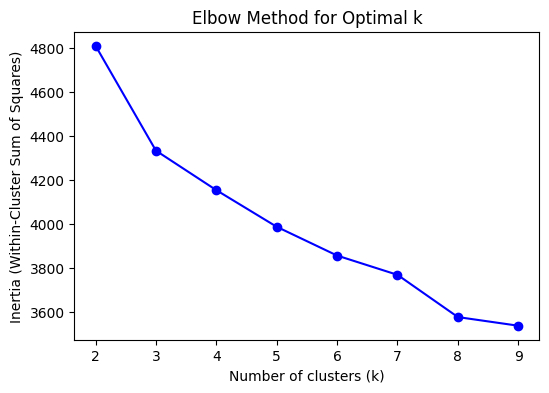

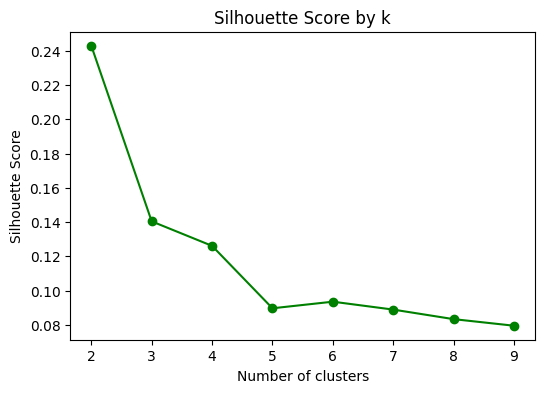

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# 1️⃣ 读取标准化后的顾客数据
df = pd.read_csv("combined_customers_standardized.csv")

# 2️⃣ 取出用于聚类的数值特征（排除 email）
X = df.drop(columns=["email","total_spent_year"])

# 3️⃣ 用“肘部法则” (Elbow Method) 选择聚类数 k
inertia = []
K = range(2, 10)  # 尝试 2~9 类
for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    inertia.append(model.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, 'o-', color='blue')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.show()

# 4️⃣ 可选：也可以计算 silhouette 分数辅助判断
silhouette = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette.append(score)

plt.figure(figsize=(6,4))
plt.plot(K, silhouette, 'o-', color='green')
plt.title('Silhouette Score by k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()






In [2]:
# 5️⃣ 选择最佳 k（假设你观察图后决定用 k=3）
k_optimal = 5
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
df["cluster"] = kmeans_final.fit_predict(X)

# 6️⃣ 查看每个聚类中心（标准化后的值）
centroids = pd.DataFrame(kmeans_final.cluster_centers_, columns=X.columns)
print("🏁 Cluster Centers (standardized scale):")
print(centroids.round(2))


🏁 Cluster Centers (standardized scale):
   Alcoholic  Appetizers  Arcade  Billiards  Bowling  Cocktail  Desserts  \
0       0.93        0.18    0.37       0.82     0.38      0.52      0.24   
1      -0.32       -0.20   -0.14      -0.22     0.01     -0.19     -0.18   
2       0.38        0.51    0.27       0.12     0.02      0.23      0.05   
3       1.05        1.07    1.49       0.83     1.05      1.47      1.45   
4      -0.83       -0.78   -0.90      -0.57    -0.68     -0.87     -0.59   

   Mains  Non-alcoholic  Salads    VR  visit_count_year  is_loyalty  
0   0.37           0.66    1.52 -0.03              0.69       -0.07  
1  -0.36          -0.27   -0.11 -0.21             -0.26        0.28  
2   0.66           0.43   -0.41  0.41              0.50       -0.23  
3   1.17           1.47    0.62  1.08              1.47        0.17  
4  -0.83          -1.00   -0.45 -0.57             -1.09       -0.20  


In [3]:
# count customers in each cluster
cluster_counts = df['cluster'].value_counts().sort_index()
print("\nNumber of customers in each cluster:")
print(cluster_counts)


Number of customers in each cluster:
cluster
0     55
1    158
2    109
3     56
4    122
Name: count, dtype: int64


In [4]:
# count customers in each cluster by is_loyal
cluster_loyal_counts = df.groupby(['cluster', 'is_loyalty']).size().unstack(fill_value=0)
print("\nNumber of customers in each cluster by loyalty status:")
print(cluster_loyal_counts)


Number of customers in each cluster by loyalty status:
is_loyalty  -1.266557   0.789542
cluster                         
0                  23         32
1                  39        119
2                  54         55
3                  17         39
4                  59         63


Cluster 0: 喜欢喝酒,台球,爱吃沙拉(分析:可能是年轻人,主要目的是娱乐而非吃饭,有身材管理的)高频来访、喜欢综合消费（酒水 + 娱乐 + 主餐），但会员比例略低。
可能是社交型顾客：朋友聚餐、喝酒娱乐并重。
策略建议：推出“餐饮 + 娱乐”套餐、鼓励注册会员。

Cluster 1: 消费水平和次数低于平均,但注册loyalty最多(分析: 为了节省而注册loyalty), 可能是“注册会员但不活跃”的群体（inactive loyalty users）。消费频次低，但会员占比高。
策略建议：用积分到期提醒、邮件促销或 personalized offer 唤醒他们

cluster 2: 消费水平高于平均水平,但注册loyalty不多, 

Cluster 3:
超高消费、全面型顾客，对所有餐饮和娱乐项目都有强烈偏好。
是你的核心高价值客户群（VIP）。
策略建议：
专属会员等级、提前预订、积分倍增日、品牌大使计划。

Cluster 4: 最低参与度群体：少访问、低消费、非会员。
多为“偶尔光顾”或一次性顾客。
策略建议：
通过欢迎优惠、首单折扣、免费游戏券激活他们；
若数据表明无回访迹象，也可视为非核心客群。

In [5]:
# 7️⃣ 导出带 cluster 的数据
df.to_csv("combined_customers_clustered.csv", index=False)

# cluster 0

Cluster 0 中 loyalty 会员人数: 32


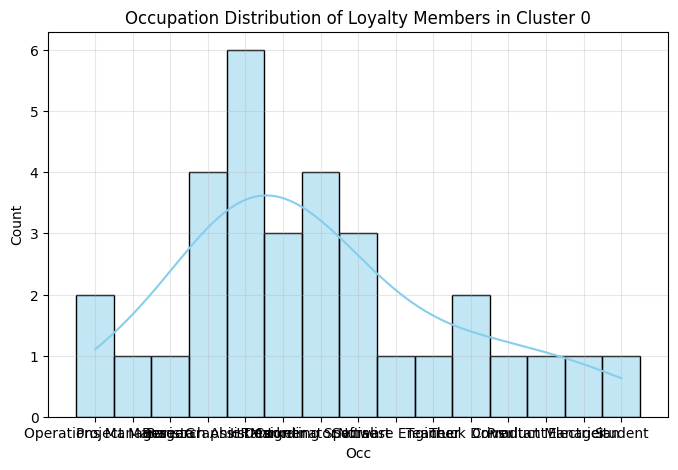

occupation
Graphic Designer        6
Research Assistant      4
Marketing Specialist    4
HR Coordinator          3
Nurse                   3
Truck Driver            2
Operations Manager      2
Project Manager         1
Barista                 1
Software Engineer       1
Teacher                 1
Consultant              1
Product Manager         1
Electrician             1
Student                 1
Name: count, dtype: int64

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取包含 cluster 标签和 loyalty 信息的文件
df = pd.read_csv("combined_customers_clustered.csv")
loyalty = pd.read_csv("datasets/loyalty_members.csv")

# 合并 loyalty 的年龄信息
merged = df.merge(loyalty[["email", "occupation"]], on="email", how="left")

# 筛选 cluster 0 且是 loyalty 会员
cluster0_loyal = merged[(merged["cluster"] == 0) & (merged["is_loyalty"] >0)]

# 检查数据数量
print(f"Cluster 0 中 loyalty 会员人数: {len(cluster0_loyal)}")

# 绘制年龄分布图
plt.figure(figsize=(8,5))
sns.histplot(cluster0_loyal["occupation"], bins=20, kde=True, color="skyblue", edgecolor="black")
plt.title("Occupation Distribution of Loyalty Members in Cluster 0")
plt.xlabel("Occ")
plt.ylabel("Count")
plt.grid(alpha=0.3) 
plt.show()
cluster0_loyal["occupation"].value_counts()

Cluster 0 中 loyalty 会员人数: 32


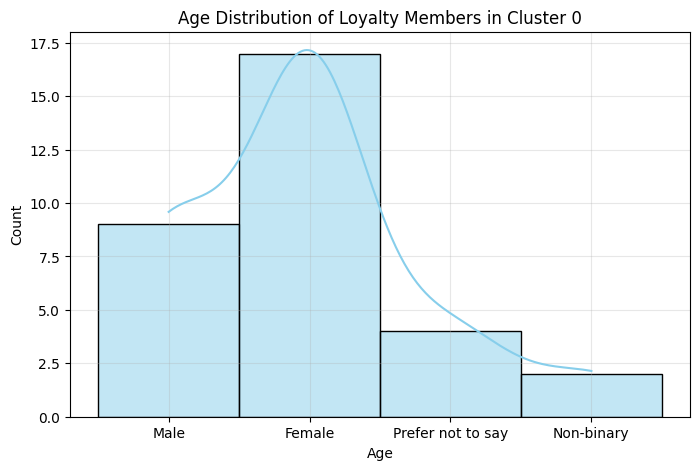

gender
Female               17
Male                  9
Prefer not to say     4
Non-binary            2
Name: count, dtype: int64

In [7]:
# 合并 loyalty 的年龄信息
merged = df.merge(loyalty[["email", "gender"]], on="email", how="left")

# 筛选 cluster 0 且是 loyalty 会员
cluster0_loyal = merged[(merged["cluster"] == 0) & (merged["is_loyalty"] >0)]

# 检查数据数量
print(f"Cluster 0 中 loyalty 会员人数: {len(cluster0_loyal)}")

# 绘制年龄分布图
plt.figure(figsize=(8,5))
sns.histplot(cluster0_loyal["gender"], bins=20, kde=True, color="skyblue", edgecolor="black")
plt.title("Age Distribution of Loyalty Members in Cluster 0")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(alpha=0.3) 
plt.show()
cluster0_loyal["gender"].value_counts()

# Cluster 1


Cluster 0 中 loyalty 会员人数: 32


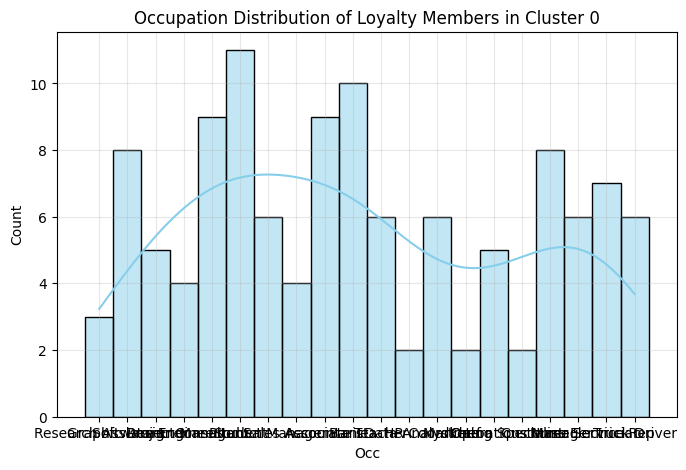

occupation
Student                 11
Barista                 10
Consultant               9
Accountant               9
Nurse                    8
Graphic Designer         8
Electrician              7
HR Coordinator           6
Truck Driver             6
Customer Service Rep     6
Teacher                  6
Product Manager          6
Software Engineer        5
Marketing Specialist     5
Sales Associate          4
Project Manager          4
Research Assistant       3
Data Analyst             2
Operations Manager       2
Chef                     2
Name: count, dtype: int64

In [8]:
# 合并 loyalty 的年龄信息
merged = df.merge(loyalty[["email", "occupation"]], on="email", how="left")

# 筛选 cluster 0 且是 loyalty 会员
cluster1_loyal = merged[(merged["cluster"] == 1) & (merged["is_loyalty"] >0)]

# 检查数据数量
print(f"Cluster 0 中 loyalty 会员人数: {len(cluster0_loyal)}")

# 绘制年龄分布图
plt.figure(figsize=(8,5))
sns.histplot(cluster1_loyal["occupation"], bins=20, kde=True, color="skyblue", edgecolor="black")
plt.title("Occupation Distribution of Loyalty Members in Cluster 0")
plt.xlabel("Occ")
plt.ylabel("Count")
plt.grid(alpha=0.3) 
plt.show()
cluster1_loyal["occupation"].value_counts()

Cluster 0 中 loyalty 会员人数: 119


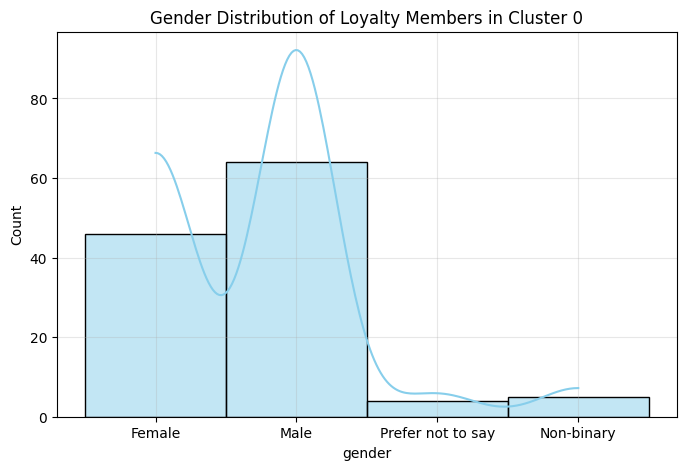

gender
Male                 64
Female               46
Non-binary            5
Prefer not to say     4
Name: count, dtype: int64

In [10]:
# 合并 loyalty 的年龄信息
merged = df.merge(loyalty[["email", "gender"]], on="email", how="left")

# 筛选 cluster 0 且是 loyalty 会员
cluster1_loyal = merged[(merged["cluster"] == 1) & (merged["is_loyalty"] >0)]

# 检查数据数量
print(f"Cluster 0 中 loyalty 会员人数: {len(cluster1_loyal)}")

# 绘制年龄分布图
plt.figure(figsize=(8,5))
sns.histplot(cluster1_loyal["gender"], bins=20, kde=True, color="skyblue", edgecolor="black")
plt.title("Gender Distribution of Loyalty Members in Cluster 0")
plt.xlabel("gender")
plt.ylabel("Count")
plt.grid(alpha=0.3) 
plt.show()
cluster1_loyal["gender"].value_counts()

# cluster 2

Cluster 2中 loyalty 会员人数: 55


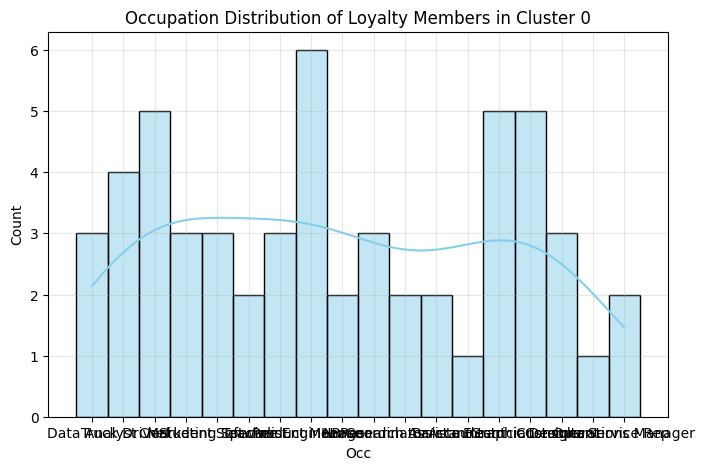

occupation
Product Manager         6
Chef                    5
Graphic Designer        5
Electrician             5
Truck Driver            4
Data Analyst            3
HR Coordinator          3
Software Engineer       3
Marketing Specialist    3
Student                 3
Consultant              3
Teacher                 2
Nurse                   2
Research Assistant      2
Operations Manager      2
Barista                 2
Accountant              1
Customer Service Rep    1
Name: count, dtype: int64

In [11]:
# 合并 loyalty 的年龄信息
merged = df.merge(loyalty[["email", "occupation"]], on="email", how="left")

# 筛选 cluster 0 且是 loyalty 会员
cluster2_loyal = merged[(merged["cluster"] == 2) & (merged["is_loyalty"] >0)]

# 检查数据数量
print(f"Cluster 2中 loyalty 会员人数: {len(cluster2_loyal)}")

# 绘制年龄分布图
plt.figure(figsize=(8,5))
sns.histplot(cluster2_loyal["occupation"], bins=20, kde=True, color="skyblue", edgecolor="black")
plt.title("Occupation Distribution of Loyalty Members in Cluster 0")
plt.xlabel("Occ")
plt.ylabel("Count")
plt.grid(alpha=0.3) 
plt.show()
cluster2_loyal["occupation"].value_counts()

Cluster 2中 loyalty 会员人数: 55


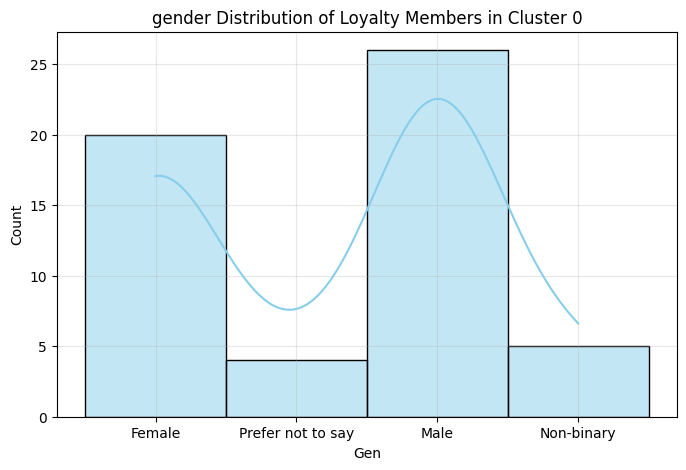

gender
Male                 26
Female               20
Non-binary            5
Prefer not to say     4
Name: count, dtype: int64

In [12]:
# 合并 loyalty 的年龄信息
merged = df.merge(loyalty[["email", "gender"]], on="email", how="left")

# 筛选 cluster 0 且是 loyalty 会员
cluster2_loyal = merged[(merged["cluster"] == 2) & (merged["is_loyalty"] >0)]

# 检查数据数量
print(f"Cluster 2中 loyalty 会员人数: {len(cluster2_loyal)}")

# 绘制年龄分布图
plt.figure(figsize=(8,5))
sns.histplot(cluster2_loyal["gender"], bins=20, kde=True, color="skyblue", edgecolor="black")
plt.title("gender Distribution of Loyalty Members in Cluster 0")
plt.xlabel("Gen")
plt.ylabel("Count")
plt.grid(alpha=0.3) 
plt.show()
cluster2_loyal["gender"].value_counts()

# Cluster 3

Cluster 2中 loyalty 会员人数: 39


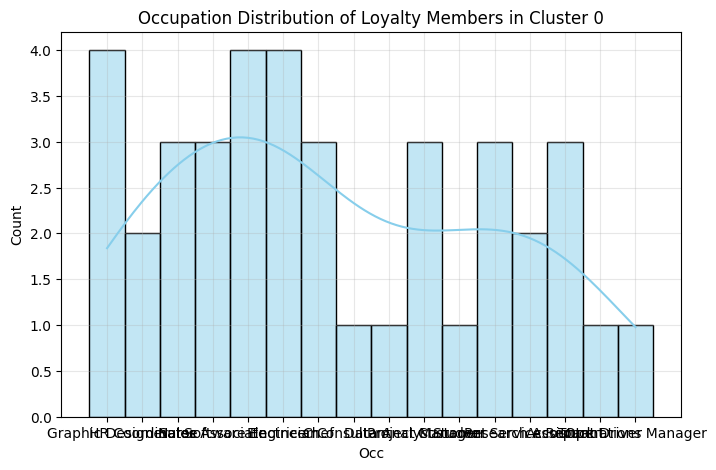

occupation
Graphic Designer        4
Software Engineer       4
Electrician             4
Nurse                   3
Chef                    3
Sales Associate         3
Customer Service Rep    3
Project Manager         3
Accountant              3
HR Coordinator          2
Research Assistant      2
Consultant              1
Student                 1
Data Analyst            1
Truck Driver            1
Operations Manager      1
Name: count, dtype: int64

In [15]:
# 合并 loyalty 的年龄信息
merged = df.merge(loyalty[["email", "occupation"]], on="email", how="left")

# 筛选 cluster 0 且是 loyalty 会员
cluster3_loyal = merged[(merged["cluster"] == 3) & (merged["is_loyalty"] >0)]

# 检查数据数量
print(f"Cluster 2中 loyalty 会员人数: {len(cluster3_loyal)}")

# 绘制年龄分布图
plt.figure(figsize=(8,5))
sns.histplot(cluster3_loyal["occupation"], bins=20, kde=True, color="skyblue", edgecolor="black")
plt.title("Occupation Distribution of Loyalty Members in Cluster 0")
plt.xlabel("Occ")
plt.ylabel("Count")
plt.grid(alpha=0.3) 
plt.show()
cluster3_loyal["occupation"].value_counts()

Cluster 2中 loyalty 会员人数: 39


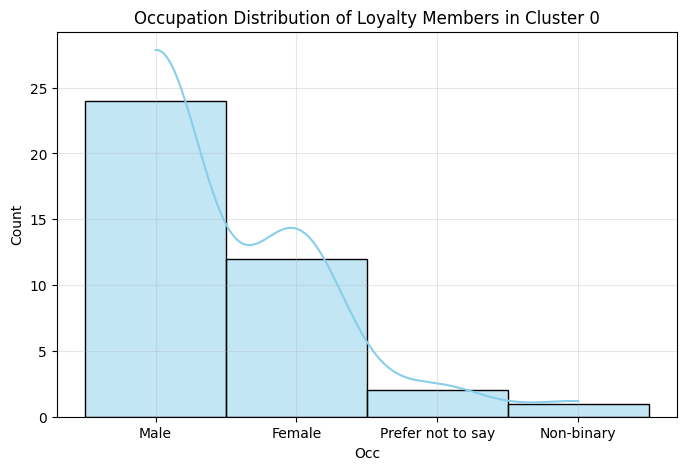

gender
Male                 24
Female               12
Prefer not to say     2
Non-binary            1
Name: count, dtype: int64

In [17]:
# 合并 loyalty 的年龄信息
merged = df.merge(loyalty[["email", "gender"]], on="email", how="left")

# 筛选 cluster 0 且是 loyalty 会员
cluster3_loyal = merged[(merged["cluster"] == 3) & (merged["is_loyalty"] >0)]

# 检查数据数量
print(f"Cluster 2中 loyalty 会员人数: {len(cluster3_loyal)}")

# 绘制年龄分布图
plt.figure(figsize=(8,5))
sns.histplot(cluster3_loyal["gender"], bins=20, kde=True, color="skyblue", edgecolor="black")
plt.title("Occupation Distribution of Loyalty Members in Cluster 0")
plt.xlabel("Occ")
plt.ylabel("Count")
plt.grid(alpha=0.3) 
plt.show()
cluster3_loyal["gender"].value_counts()

# Cluster 4

Cluster 2中 loyalty 会员人数: 39


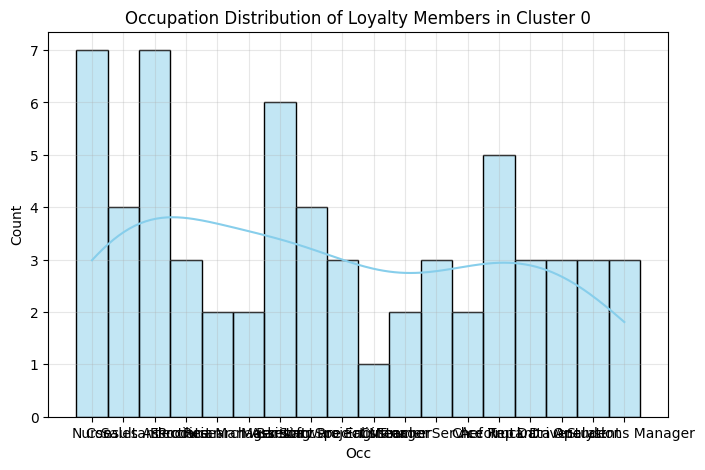

occupation
Nurse                   7
Sales Associate         7
Barista                 6
Accountant              5
Consultant              4
Marketing Specialist    4
Software Engineer       3
Data Analyst            3
Customer Service Rep    3
Electrician             3
Student                 3
Operations Manager      3
Truck Driver            3
Product Manager         2
Chef                    2
Research Assistant      2
Teacher                 2
Project Manager         1
Name: count, dtype: int64

In [18]:
# 合并 loyalty 的年龄信息
merged = df.merge(loyalty[["email", "occupation"]], on="email", how="left")

# 筛选 cluster 0 且是 loyalty 会员
cluster4_loyal = merged[(merged["cluster"] == 4) & (merged["is_loyalty"] >0)]

# 检查数据数量
print(f"Cluster 2中 loyalty 会员人数: {len(cluster3_loyal)}")

# 绘制年龄分布图
plt.figure(figsize=(8,5))
sns.histplot(cluster4_loyal["occupation"], bins=20, kde=True, color="skyblue", edgecolor="black")
plt.title("Occupation Distribution of Loyalty Members in Cluster 0")
plt.xlabel("Occ")
plt.ylabel("Count")
plt.grid(alpha=0.3) 
plt.show()
cluster4_loyal["occupation"].value_counts()

Cluster 2中 loyalty 会员人数: 39


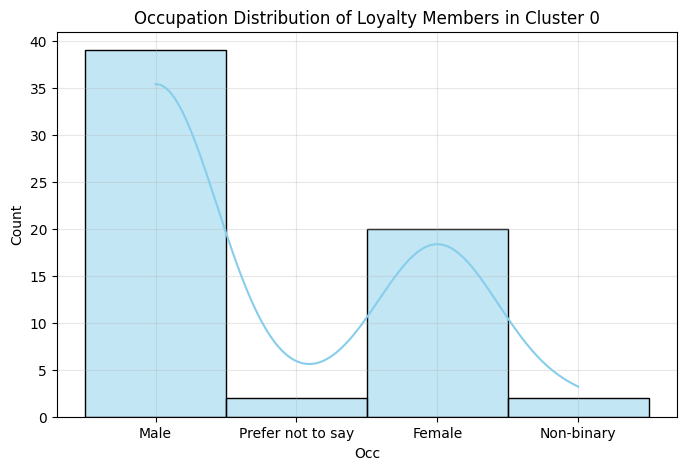

gender
Male                 39
Female               20
Prefer not to say     2
Non-binary            2
Name: count, dtype: int64

In [19]:
# 合并 loyalty 的年龄信息
merged = df.merge(loyalty[["email", "gender"]], on="email", how="left")

# 筛选 cluster 0 且是 loyalty 会员
cluster4_loyal = merged[(merged["cluster"] == 4) & (merged["is_loyalty"] >0)]

# 检查数据数量
print(f"Cluster 2中 loyalty 会员人数: {len(cluster3_loyal)}")

# 绘制年龄分布图
plt.figure(figsize=(8,5))
sns.histplot(cluster4_loyal["gender"], bins=20, kde=True, color="skyblue", edgecolor="black")
plt.title("Occupation Distribution of Loyalty Members in Cluster 0")
plt.xlabel("Occ")
plt.ylabel("Count")
plt.grid(alpha=0.3) 
plt.show()
cluster4_loyal["gender"].value_counts()